# Data Processing

## Explore data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder,StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_predict
from sklearn.metrics import accuracy_score, f1_score,precision_score,mean_squared_error, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

In [2]:
# import data 
train = pd.read_csv('/kaggle/input/simulates-real-world-agricultural-data/train.csv')
test = pd.read_csv('/kaggle/input/simulates-real-world-agricultural-data/test.csv')
# Display the first few rows of the dataset
train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [3]:
test.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


In [4]:
print(f'{len(test)/len(train):.2f}')

0.33


In [5]:
# check any null value
print(train.isnull().sum())

id                 0
Temparature        0
Humidity           0
Moisture           0
Soil Type          0
Crop Type          0
Nitrogen           0
Potassium          0
Phosphorous        0
Fertilizer Name    0
dtype: int64


In [6]:
# Print the data information
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB
None


There are 10 columns with 750000 rows, without any null values. 'Soli Type', 'Crop Type' and 'Fertilizer Name' are catogory type, others are numeric type.

In [7]:
# Print statistics
print(train.describe())

                  id    Temparature       Humidity       Moisture  \
count  750000.000000  750000.000000  750000.000000  750000.000000   
mean   374999.500000      31.503565      61.038912      45.184147   
std    216506.495284       4.025574       6.647695      11.794594   
min         0.000000      25.000000      50.000000      25.000000   
25%    187499.750000      28.000000      55.000000      35.000000   
50%    374999.500000      32.000000      61.000000      45.000000   
75%    562499.250000      35.000000      67.000000      55.000000   
max    749999.000000      38.000000      72.000000      65.000000   

            Nitrogen      Potassium    Phosphorous  
count  750000.000000  750000.000000  750000.000000  
mean       23.093808       9.478296      21.073227  
std        11.216125       5.765622      12.346831  
min         4.000000       0.000000       0.000000  
25%        13.000000       4.000000      10.000000  
50%        23.000000       9.000000      21.000000  
75%    

Base on the describe, the data range is resonable,so no normalization needed.

# Data Preprocessing

### Encode Categorical Variables

In [8]:
le_soil = LabelEncoder()
le_crop = LabelEncoder()
le_fert = LabelEncoder()

train['Soil Type'] = le_soil.fit_transform(train['Soil Type'])
train['Crop Type'] = le_crop.fit_transform(train['Crop Type'])
train['Fertilizer Name'] = le_fert.fit_transform(train['Fertilizer Name'])

test['Soil Type'] = le_soil.transform(test['Soil Type'])
test['Crop Type'] = le_crop.transform(test['Crop Type'])

In [9]:
# Save ID for submission
test_ids = test['id']

# Drop ID before prediction
X_test = test.drop(columns=['id'])

In [10]:
# Define features and target
X_train = train.drop(['id','Fertilizer Name'], axis=1)
y_train = train['Fertilizer Name']

### Check data balance

<Axes: xlabel='Fertilizer Name'>

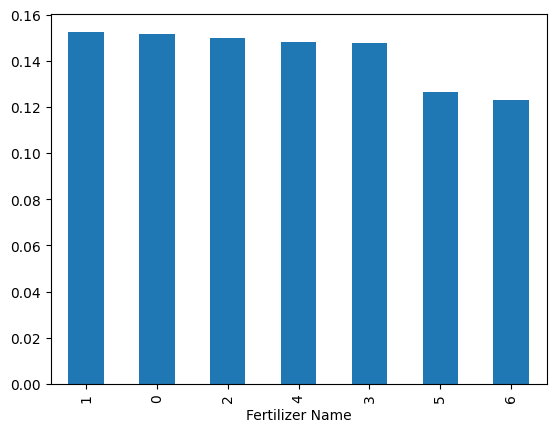

In [11]:
train['Fertilizer Name'].value_counts(normalize=True).plot(kind='bar')

The class distribution for the target variable 'Fertilizer Name' is fairly balanced.

# Model Training

In [12]:
def evaluate_metrics(y_true, y_pred):
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("F1-score:", round(f1_score(y_true, y_pred, average="weighted"), 4))
    print("Precision:", round(precision_score(y_true, y_pred, average="weighted"), 4))
    print("Recall (Sensitivity):", round(recall_score(y_true, y_pred, average="weighted"), 4))
    print("Mean Squared Error:", round(mean_squared_error(y_true, y_pred), 4))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

In [13]:
# Use cross-validation-friendly split for balanced classes
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Model 1: XGBoost Model

Cross-Validation Results:
Accuracy: 0.1864
F1-score: 0.1767
Precision: 0.1871
Recall (Sensitivity): 0.1864
Mean Squared Error: 6.7285

Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.23      0.21    113887
           1       0.19      0.27      0.22    114436
           2       0.19      0.23      0.21    112453
           3       0.18      0.18      0.18    110889
           4       0.18      0.22      0.20    111158
           5       0.20      0.09      0.12     94860
           6       0.19      0.04      0.07     92317

    accuracy                           0.19    750000
   macro avg       0.19      0.18      0.17    750000
weighted avg       0.19      0.19      0.18    750000



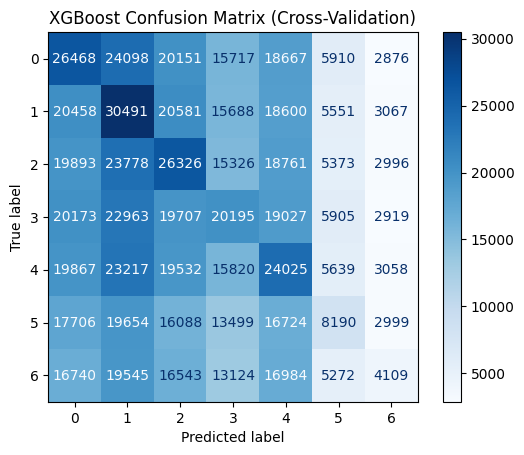

In [14]:
# Initialize XGB model
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=7,
    random_state=42,
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5
)

# Cross-validation setup (using your predefined cv)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validated predictions
cv_preds = cross_val_predict(xgb, X_train, y_train, cv=cv)

# Evaluate metrics using your function
print("Cross-Validation Results:")
evaluate_metrics(y_train, cv_preds)

# Confusion matrix
cm = confusion_matrix(y_train, cv_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('XGBoost Confusion Matrix (Cross-Validation)')
plt.show()


In [15]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None, num_class=7,
              num_parallel_tree=None, ...)

In [16]:
probs = xgb.predict_proba(X_test)
top3_preds = np.argsort(probs, axis=1)[:, -3:][:, ::-1]

In [17]:
top3_names = np.array([le_fert.inverse_transform(row) for row in top3_preds])

In [18]:
# Join the top 3 fertilizer names into space-separated strings per row
fertilizer_strings = [' '.join(row) for row in top3_names]

# Build submission DataFrame
submission = pd.DataFrame({
    'id': test_ids,
    'Fertilizer Name': fertilizer_strings
})

# Save to CSV with header
submission.to_csv('submission.csv', index=False)
print("Submission saved as 'submission.csv'")

Submission saved as 'submission.csv'


In [19]:
submission.head()

,id,Fertilizer Name
0,750000,28-28 DAP 14-35-14
1,750001,17-17-17 20-20 14-35-14
2,750002,14-35-14 10-26-26 28-28
3,750003,14-35-14 17-17-17 10-26-26
4,750004,20-20 17-17-17 10-26-26
